# **Data**

In [45]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CombinedSegmentationDataset(Dataset):
    def __init__(self, datasets, transform=None):
        """
        datasets: List of (image_dir, mask_dir) tuples.
        transform: Transform to be applied to the images and masks.
        """
        self.datasets = datasets
        self.image_paths = []
        self.mask_paths = []
        
        # Collect image and mask paths from all datasets
        for image_dir, mask_dir in datasets:
            image_paths = sorted(os.listdir(image_dir))  # Sort to ensure image-mask alignment
            mask_paths = sorted(os.listdir(mask_dir))
            self.image_paths.extend([os.path.join(image_dir, p) for p in image_paths])
            self.mask_paths.extend([os.path.join(mask_dir, p) for p in mask_paths])
        
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Assuming masks are grayscale images

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Example usage:
image_dir_1 = '/kaggle/input/river-water-segmentation-dataset/riwa_v2/images'
mask_dir_1 = '/kaggle/input/river-water-segmentation-dataset/riwa_v2/masks'
image_dir_2 = '/kaggle/input/water-segmentation-dataset/water_v2/water_v2/JPEGImages/ADE20K'
mask_dir_2 = '/kaggle/input/water-segmentation-dataset/water_v2/water_v2/Annotations/ADE20K'

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images and masks to a consistent size
    transforms.ToTensor(),
])

# Define both datasets
dataset1 = (image_dir_1, mask_dir_1)
dataset2 = (image_dir_2, mask_dir_2)

# Combine both datasets into a single CombinedSegmentationDataset
combined_dataset = CombinedSegmentationDataset(datasets=[dataset1, dataset2], transform=transform)

# Create DataLoader
dataloader = DataLoader(combined_dataset, batch_size=8, shuffle=True)

In [46]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained FCN model
model = models.segmentation.fcn_resnet50(pretrained=True)

model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1))  # Adjust for binary segmentation

# Set the device to 'cuda' and wrap the model with DataParallel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap model in DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [47]:
import torch.optim as optim

# Loss function: Binary Cross-Entropy
criterion = nn.BCEWithLogitsLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [48]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Setup for optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Track losses and IoUs
train_losses = []
train_ious = []

def calculate_iou(pred, target):
    intersection = (pred & target).sum((1, 2))  # Sum over height and width dimensions
    union = (pred | target).sum((1, 2))         # Sum over height and width dimensions
    iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
    return iou.mean().item()                     # Return mean IoU for batch

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    num_batches = 0
    
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out'].squeeze(1)  # Remove extra channel dimension
        masks = masks.squeeze(1)

        # Compute the loss
        loss = criterion(outputs, masks.float())  # Ensure masks are float for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        
        # Calculate IoU
        predicted_masks = (torch.sigmoid(outputs) > 0.5).int()  # Threshold for binary mask
        iou = calculate_iou(predicted_masks, masks.int())  # Ensure masks are integer type for IoU
        running_iou += iou
        
        running_loss += loss.item()
        num_batches += 1

    # Average loss and IoU for the epoch
    avg_loss = running_loss / num_batches
    avg_iou = running_iou / num_batches
    train_losses.append(avg_loss)
    train_ious.append(avg_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

100%|██████████| 379/379 [03:38<00:00,  1.74it/s]


Epoch [1/10], Loss: 0.2878, IoU: 0.5489


100%|██████████| 379/379 [03:37<00:00,  1.75it/s]


Epoch [2/10], Loss: 0.2011, IoU: 0.6441


100%|██████████| 379/379 [03:36<00:00,  1.75it/s]


Epoch [3/10], Loss: 0.1657, IoU: 0.6769


100%|██████████| 379/379 [03:37<00:00,  1.74it/s]


Epoch [4/10], Loss: 0.1295, IoU: 0.7126


100%|██████████| 379/379 [03:37<00:00,  1.75it/s]


Epoch [5/10], Loss: 0.1142, IoU: 0.7341


100%|██████████| 379/379 [03:37<00:00,  1.74it/s]


Epoch [6/10], Loss: 0.1056, IoU: 0.7421


100%|██████████| 379/379 [03:36<00:00,  1.75it/s]


Epoch [7/10], Loss: 0.1011, IoU: 0.7513


100%|██████████| 379/379 [03:36<00:00,  1.75it/s]


Epoch [8/10], Loss: 0.0907, IoU: 0.7641


100%|██████████| 379/379 [03:37<00:00,  1.75it/s]


Epoch [9/10], Loss: 0.0781, IoU: 0.7834


100%|██████████| 379/379 [03:36<00:00,  1.75it/s]

Epoch [10/10], Loss: 0.0687, IoU: 0.7991


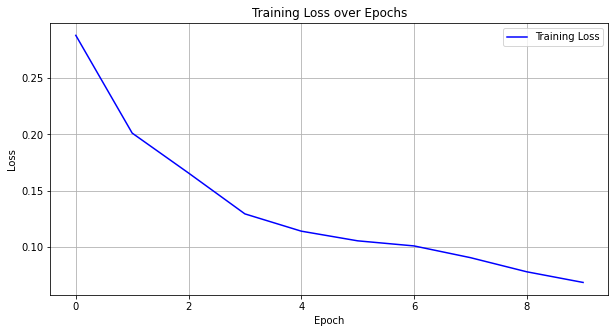

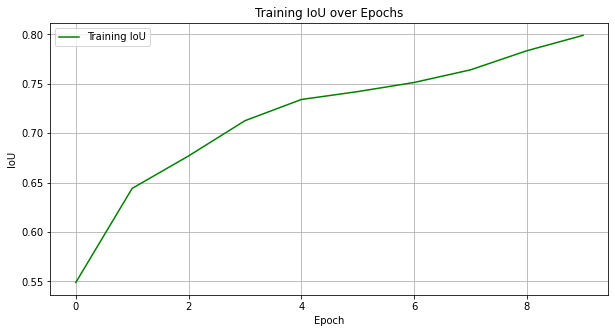

In [49]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training IoU
plt.figure(figsize=(10, 5))
plt.plot(train_ious, label='Training IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training IoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()

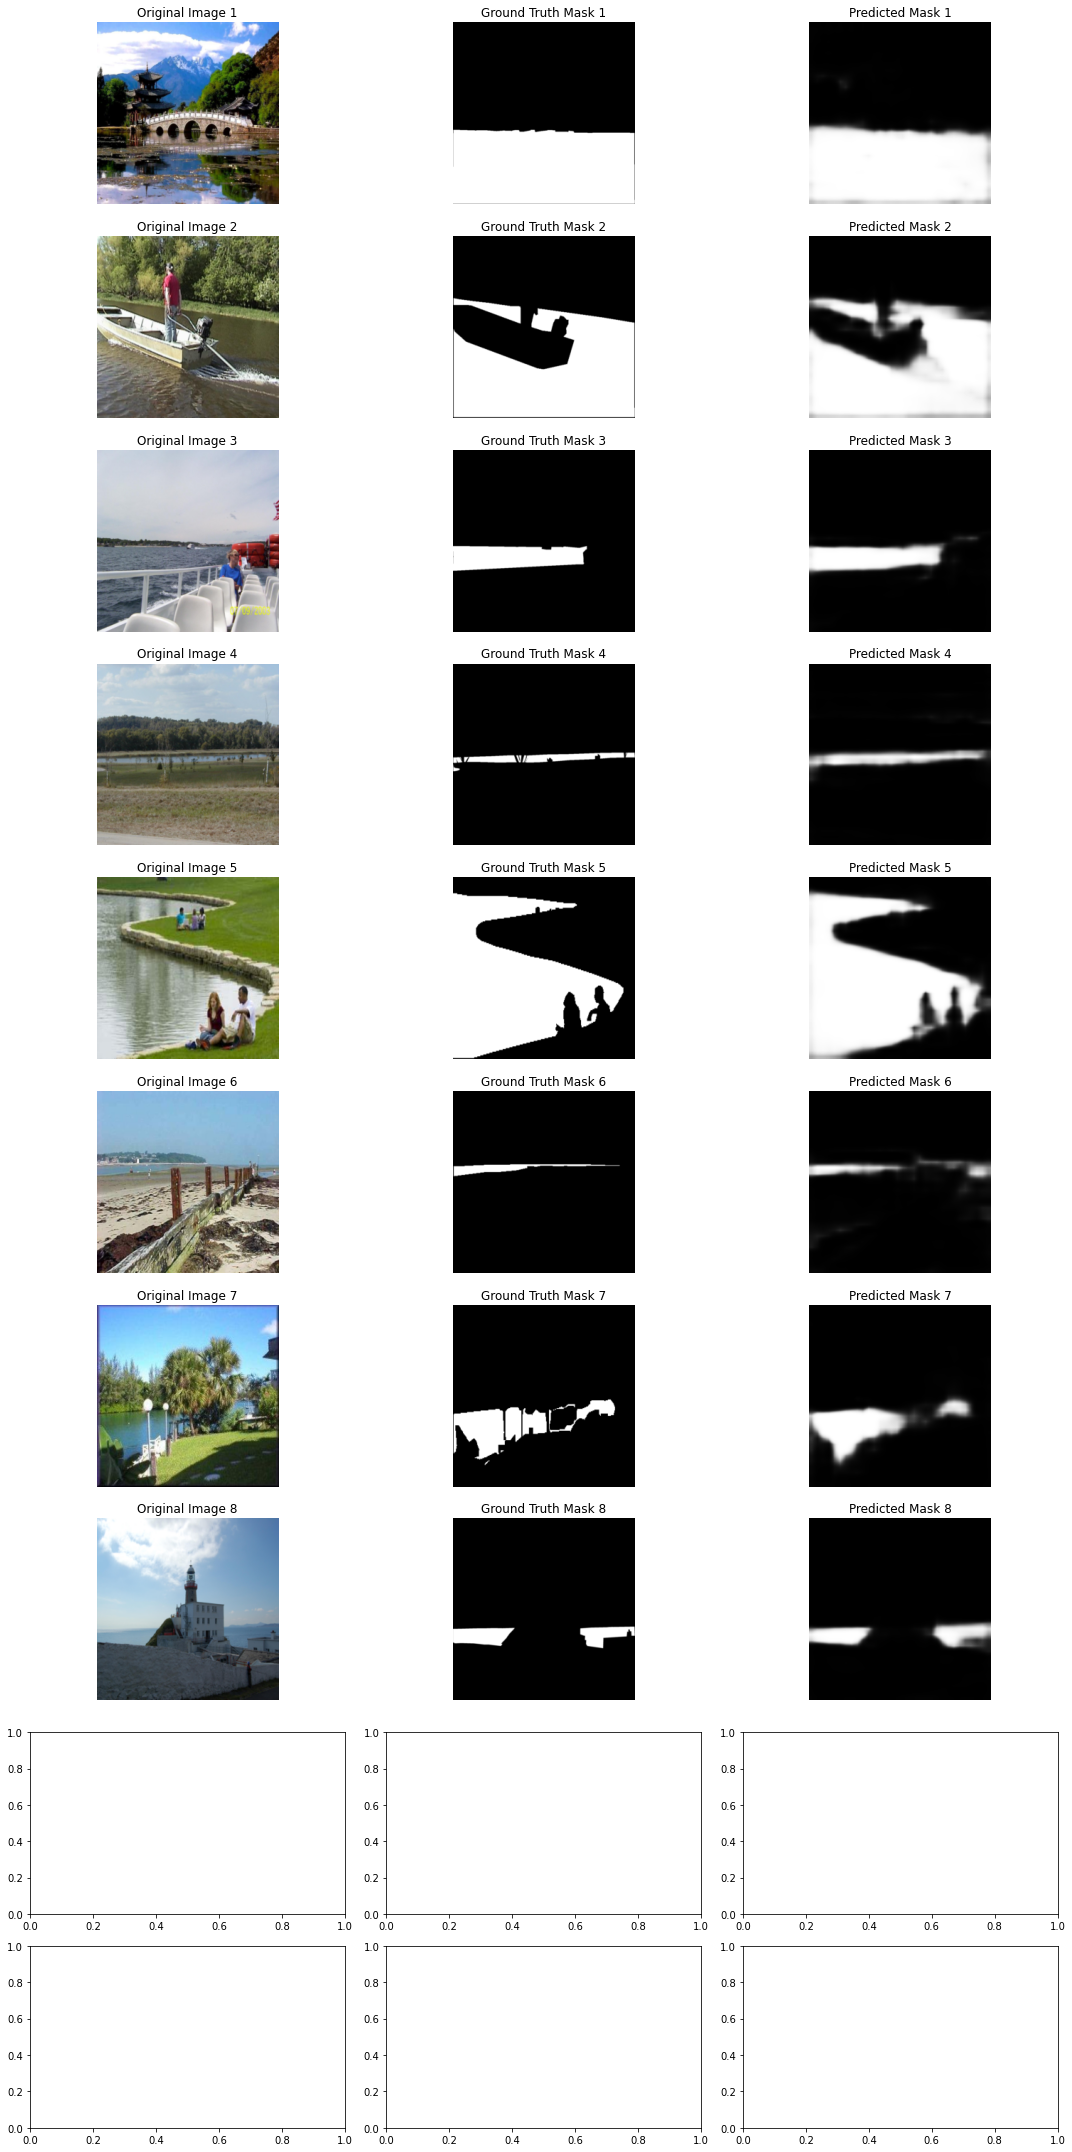

In [33]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Assuming 'model' is your trained model and you're working on a batch of images
model.eval()  # Set the model to evaluation mode

# Get a batch of images and masks from your validation dataloader
images, masks = next(iter(dataloader))

# Send to the same device as the model (e.g., CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images = images.to(device)
masks = masks.to(device)

# Forward pass to get the predicted output
with torch.no_grad():  # Disable gradient calculation
    outputs = model(images)['out']  # FCN returns a dictionary with 'out' key
    predicted_masks = torch.sigmoid(outputs).squeeze(1)  # Sigmoid and squeeze to remove channel dimension

# Convert to CPU and numpy for plotting
images = images.cpu().numpy()
masks = masks.cpu().numpy()
predicted_masks = predicted_masks.cpu().numpy()

# Set up the plot with 10 rows (for 10 images) and 3 columns
fig, axes = plt.subplots(10, 3, figsize=(15, 30))

for i in range(8):
    # Display the original image (all channels in color)
    axes[i, 0].imshow(images[i].transpose(1, 2, 0))  # Transpose to (height, width, channels) for RGB display
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Display the ground truth mask
    axes[i, 1].imshow(masks[i, 0], cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(predicted_masks[i], cmap='gray')
    axes[i, 2].set_title(f'Predicted Mask {i+1}')
    axes[i, 2].axis('off')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


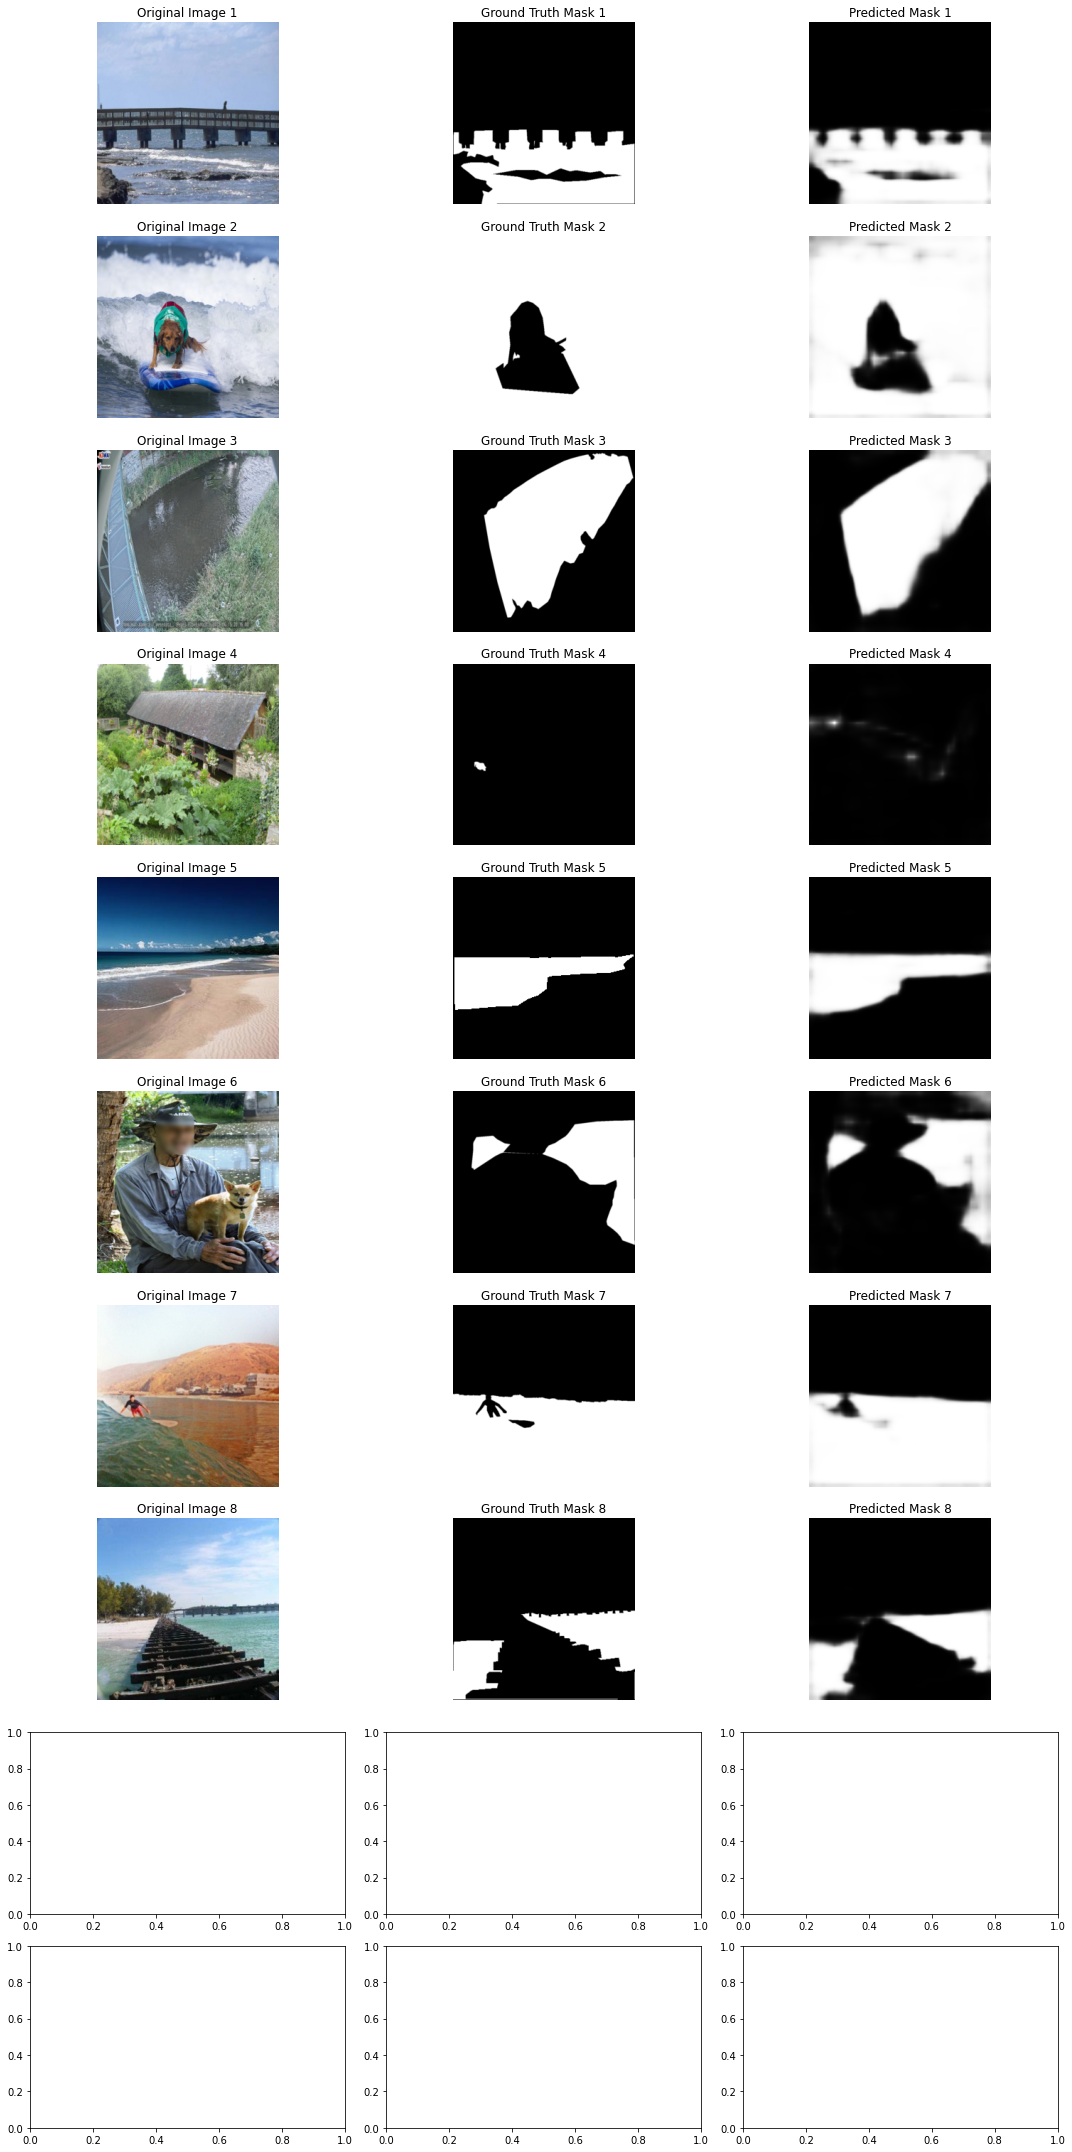

In [50]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Assuming 'model' is your trained model and you're working on a batch of images
model.eval()  # Set the model to evaluation mode

# Get a batch of images and masks from your validation dataloader
images, masks = next(iter(dataloader))

# Send to the same device as the model (e.g., CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images = images.to(device)
masks = masks.to(device)

# Forward pass to get the predicted output
with torch.no_grad():  # Disable gradient calculation
    outputs = model(images)['out']  # FCN returns a dictionary with 'out' key
    predicted_masks = torch.sigmoid(outputs).squeeze(1)  # Sigmoid and squeeze to remove channel dimension

# Convert to CPU and numpy for plotting
images = images.cpu().numpy()
masks = masks.cpu().numpy()
predicted_masks = predicted_masks.cpu().numpy()

# Set up the plot with 10 rows (for 10 images) and 3 columns
fig, axes = plt.subplots(10, 3, figsize=(15, 30))

for i in range(8):
    # Display the original image (all channels in color)
    axes[i, 0].imshow(images[i].transpose(1, 2, 0))  # Transpose to (height, width, channels) for RGB display
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Display the ground truth mask
    axes[i, 1].imshow(masks[i, 0], cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(predicted_masks[i], cmap='gray')
    axes[i, 2].set_title(f'Predicted Mask {i+1}')
    axes[i, 2].axis('off')

# Adjust layout for better readability
plt.tight_layout()
plt.show()